# Regresión Lineal

En este notebook vamos a utilizar el dataset de la clase 3 (happiness-income), para explorar otras propiedades del modelo de regresión lineal:

* Convexidad del Error Cuadrático Medio
* Correlación de Features
* Variabilidad y $R^{2}$


## Cargamos el dataset y las clases de los modelos y métricas

In [1]:
import numpy as np
import matplotlib.pyplot as plt


### Clase Data para cargar el dataset y hacer el split

In [2]:
class Data(object):

    def __init__(self, path):
        self.dataset = self._build_dataset(path)

    @staticmethod
    def _build_dataset(path):
        structure = [('income', float),
                     ('happiness', float)]

        with open(path, encoding="utf8") as data_csv:
            data_gen = ((float(line.split(',')[1]), float(line.split(',')[2]))
                        for i, line in enumerate(data_csv) if i != 0)
            data = np.fromiter(data_gen, structure)

        return data

    def split(self, percentage):  # 0.8
        X = self.dataset['income']
        y = self.dataset['happiness']

        # X.shape[0] -> 10 (filas)

        permuted_idxs = np.random.permutation(X.shape[0])
        # 2,1,3,4,6,7,8,5,9,0

        train_idxs = permuted_idxs[0:int(percentage * X.shape[0])]
        # permuted_idxs[0:8]
        # [2,1,3,4,5,6,7,8,5]

        test_idxs = permuted_idxs[int(percentage * X.shape[0]): X.shape[0]]
        # [9,0]

        X_train = X[train_idxs]
        X_test = X[test_idxs]

        y_train = y[train_idxs]
        y_test = y[test_idxs]

        return X_train, X_test, y_train, y_test


### Clases de Modelos Base y Regresión Lineal y Afín

In [3]:
class BaseModel(object):

    def __init__(self):
        self.model = None

    def fit(self, X, Y):
        return NotImplemented

    def predict(self, X):
        return NotImplemented


class ConstantModel(BaseModel):

    def fit(self, X, Y):
        W = Y.mean()
        self.model = W

    def predict(self, X):
        return np.ones(len(X)) * self.model


class LinearRegression(BaseModel):

    def fit(self, X, y):
        if len(X.shape) == 1:
            W = X.T.dot(y) / X.T.dot(X)
        else:
            W = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.model = W

    def predict(self, X):
        return self.model * X


class LinearRegressionWithB(BaseModel):

    def fit(self, X, y):
        X_expanded = np.vstack((X, np.ones(len(X)))).T
        W = np.linalg.inv(X_expanded.T.dot(X_expanded)).dot(X_expanded.T).dot(y)
        self.model = W

    def predict(self, X):
        X_expanded = np.vstack((X, np.ones(len(X)))).T
        return X_expanded.dot(self.model)


### Clases de Métricas

In [4]:
class Metric(object):
    def __call__(self, target, prediction):
        return NotImplemented


class MSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n

### Cargamos el dataset

In [5]:
dataset = Data(r'../../clase_3/ejercicios/data/income.csv')
X_train, X_test, y_train, y_test = dataset.split(0.8)

In [6]:
X_train.shape

(398,)

In [7]:
y_train.shape

(398,)

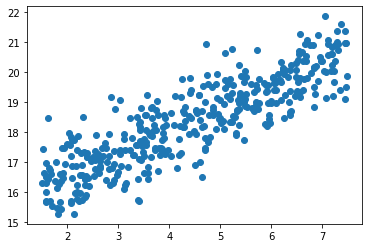

In [8]:
plt.scatter(X_train, y_train+15)
plt.show()

In [9]:
mse = MSE()

In [10]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
lr_y_hat = linear_regression.predict(X_test)
lr_mse = mse(y_test, lr_y_hat)

In [11]:
linear_regression.model

0.753650921391578

In [12]:
lr_mse

0.4483062597124851

In [13]:
linear_regression_b = LinearRegressionWithB()
linear_regression_b.fit(X_train, y_train+15)
lrb_y_hat = linear_regression_b.predict(X_test)
lrb_mse = mse(y_test, lrb_y_hat)

In [14]:
linear_regression_b.model

array([ 0.72746779, 15.13348921])

In [39]:
lrb_mse

223.9632200284323

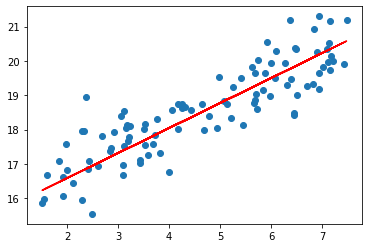

In [16]:
plt.scatter(X_test, y_test+15)
plt.plot(X_test, lrb_y_hat, 'r')

### Graficamos el Error Cuadrático Medio

In [17]:
def ECM_graph(X,y,w):
    ecm=0.0
    for n,val in enumerate(y):
        y_est = w[0] + w[1]*X[n]
        ecm = ecm + (y_est - y[n])**2
    return ecm/len(y)

In [18]:
# Armamos una grilla con un rango de valores de los pesos
w0 = np.arange(-50,50,1)
w1 = np.arange(-50,50,1)
X0, Y0 = np.meshgrid(w0, w1)

In [19]:
# Calculamos el ECM para todos los posibles valores de w del rango elegido
Z = ECM_graph(X_train,y_train,[X0,Y0])

In [20]:
from mpl_toolkits import mplot3d

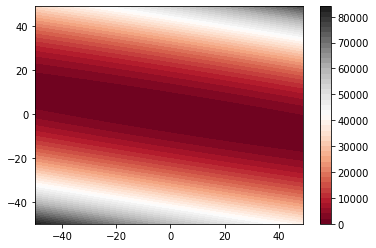

In [21]:
plt.contourf(X0, Y0, Z, 50, cmap='RdGy')
plt.colorbar()

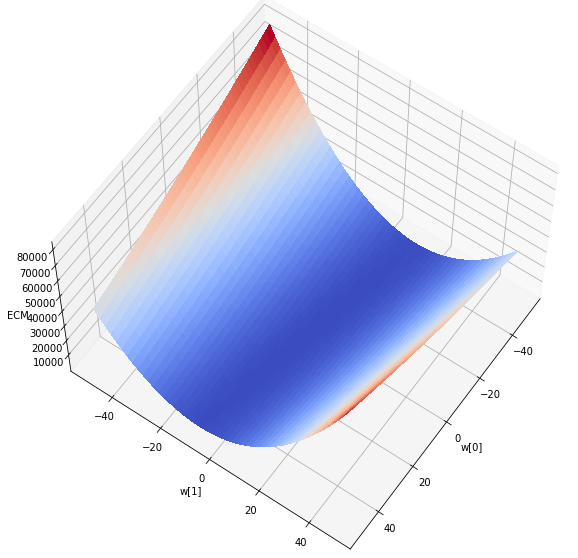

In [22]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(X0, Y0, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlabel('ECM')
ax.set_xlabel('w[0]')
ax.set_ylabel('w[1]')
ax.view_init(60, 35)

In [23]:
## Agregamos una feature con alta correlación con la existente. Planteamos un modelo sin intercept.

X_corr = X_train.reshape(-1, 1)
X_corr = np.hstack((X_corr, X_corr*1.5 + 50))

In [24]:
X_corr.shape

(398, 2)

In [25]:
from scipy.stats import pearsonr

# calculamos la correlación con Pearson
corr, _ = pearsonr(X_corr[0, :], X_corr[1, :])
print('Coeficiente de Correlación: %.3f' % corr)

Coeficiente de Correlación: 1.000


In [26]:
def ECM_graph_corr(X,y,w):
    ecm=0.0
    for n,val in enumerate(y):
        y_est = w[0] + w[1]*X[n, 0] + w[2]*X[n, 1]
        ecm = ecm + (y_est - y[n])**2
    return ecm/len(y)

In [27]:
w2 = np.arange(-50,50,1)
X0, Y0 , Z0= np.meshgrid(w0, w1, w2)

In [28]:
# Calculamos el ECM para todos los posibles valores de w del rango elegido
Z = ECM_graph_corr(X_corr,y_train,[X0,Y0, Z0])

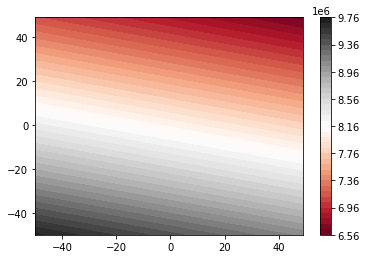

In [29]:
plt.contourf(X0[:,:,0], Y0[:,:,0], Z[:,:,0], 50, cmap='RdGy')
plt.colorbar()
plt.show()

¿Qué método podríamos usar que vimos en clase para solucionarlo?

## Variabilidad y $R^{2}$ 

In [36]:
def r_squared_lr(X, y, y_hat):
    n = y.size
    var_media = np.sum((y - np.mean(y)) ** 2) / n
    var_fit = np.sum((y - y_hat) ** 2) / n
    return (var_media - var_fit)/var_media

In [54]:
lrb_r2 = r_squared_lr(X_train, y_train, linear_regression_b.predict(X_train))

In [55]:
lrb_r2

-105.84199986992502

In [53]:
lrb_r2_ = r_squared_lr(X_train, y_train, linear_regression_b.predict(X_train)-15)

In [56]:
lrb_r2_

0.7467928139620922

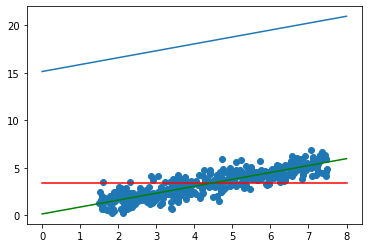

In [50]:
f , ax = plt.subplots()
eje = np.linspace(0,8,400)
ax.scatter(X_train, y_train)

ax.plot(eje,linear_regression_b.predict(eje))
ax.plot(eje,np.ones(eje.shape)*np.mean(y_train), color='red')
ax.plot(eje,linear_regression_b.predict(eje)-15, color='green')


plt.show()

In [38]:
lrb_r2

-105.84199986992502

In [33]:
## Calculamos el R2 para el modelo constante
constant_model = ConstantModel()
constant_model.fit(X_train, y_train)
ct_y_hat = constant_model.predict(X_test)


In [34]:
cm_r2 = r_squared_lr(X_train, y_train, constant_model.predict(X_train))

In [35]:
cm_r2

0.0